# 関数の定義

In [2]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special
import openpyxl
from openpyxl import Workbook, load_workbook
from openpyxl.chart import ScatterChart, LineChart, Reference, Series
from openpyxl.chart.shapes import GraphicalProperties
from openpyxl.chart.layout import Layout, ManualLayout
from openpyxl.chart.text import RichText
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties, Font, RichTextProperties
from openpyxl.drawing.line import LineProperties
from copy import deepcopy
print('ok')

ok


In [3]:
#####関数の定義##############################################
def Gaussian(x, *params):
    num_Gaussian = int(len(params)/3)
    y_list = []
    for i in range(num_Gaussian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])] #全半値幅
        y = y + amp*np.exp(-((x-ctr)/wid)**2/2)
        y_list.append(y)
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i
    y_sum = y_sum + params[-1]
    return y_sum

def Lorentzian(x, *params):
    num_Lorentzian = int(len(params)/3)
    y_list = []
    for i in range(num_Lorentzian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])] 
        ctr = params[int(param_range[1])] 
        wid = params[int(param_range[2])] #HWFM
        y = y + amp*(wid**2/(4*(x-ctr)**2+wid**2)) 
        y_list.append(y)
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i
    y_sum = y_sum + params[-1]
    return y_sum

def Voigt(x, *params):
    num_Voigt = int(len(params)/4)
    y_list = []
    for i in range(num_Voigt):
        y = np.zeros_like(x)
        param_range = list(range(4*i,4*(i+1),1))
        norm = params[int(param_range[0])] #normalization
        ctr = params[int(param_range[1])] #center of Lorentzian line
        lw = params[int(param_range[2])] #HWFM of Lorentzian 
        gw = params[int(param_range[3])] #sigma of the Gaussian
        z = (x - ctr + 1j*lw)/(gw * np.sqrt(2.0))
        w = scipy.special.wofz(z)
        y = y + norm*(w.real)/(gw * np.sqrt(2.0*np.pi))
        y_list.append(y)
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i
    y_sum = y_sum + params[-1]
    return y_sum

def plot_G(x, *params):
    num_Gaussian = int(len(params)/3)
    y_list = []
    for i in range(num_Gaussian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])] #HWHM
        y = y + amp*np.exp(-((x-ctr)/wid)**2/2) + params[-1]
        y_list.append(y)
    return y_list

def plot_L(x, *params):
    num_Lorentzian = int(len(params)/3)
    y_list = []
    for i in range(num_Lorentzian):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])] 
        ctr = params[int(param_range[1])] 
        wid = params[int(param_range[2])] #FWHM
        y = y + amp*(wid**2/(4*(x-ctr)**2+wid**2))  + params[-1]
        y_list.append(y)
    return y_list

def plot_V(x, *params):
    num_Voigt = int(len(params)/4)
    y_list = []
    for i in range(num_Voigt):
        y = np.zeros_like(x)
        param_range = list(range(4*i,4*(i+1),1))
        norm = params[int(param_range[0])] #normalization
        ctr = params[int(param_range[1])] #center of Lorentzian line
        lw = params[int(param_range[2])] #HWFM of Lorentzian 
        gw = params[int(param_range[3])] #sigma of the Gaussian
        z = (x - ctr + 1j*lw)/(gw * np.sqrt(2.0))
        w = scipy.special.wofz(z)
        y = y + norm*(w.real)/(gw * np.sqrt(2.0*np.pi))
        y_list.append(y)
    return y_list

def num_peak(*params):
    num_peak=int(len(params)/3)
    return num_peak
print('ok')

ok


# 2θ/ω-scan

Text(0, 0.5, 'Intensity')

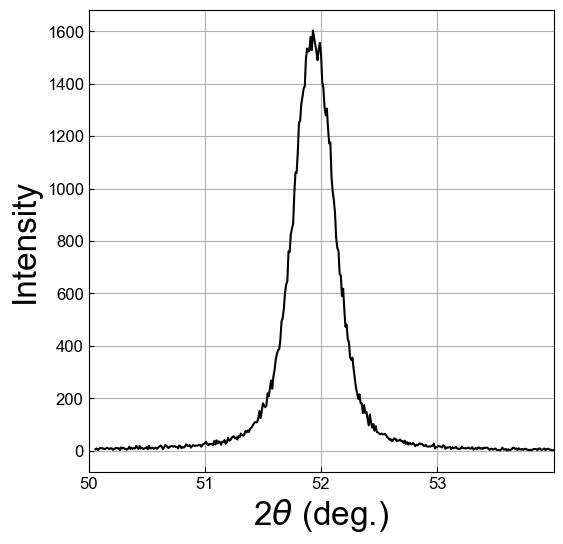

In [58]:
#####データの代入############################################
Path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd' #データファイルのパス
dataname='240726' #データのはいっているファイルの名前
filename='240304nc20_4_020' #生データの名前
save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/新試料/xrd' #保存先のパス
K=0.9 #Scherrer定数(結晶粒径を求めるときに使用)

#リストの作成
x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

#表示する角度2θ
tths=50 #開始
tthe=54 #終了

#ファイルを開く
f= open(f'{Path}/{dataname}/{filename}.txt','rt')

#初めの余計な情報を飛ばす
for i in range(226):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if tths<= float(data[0]) <=tthe:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(6.0, 6.0))

#plt.yscale('log')
plt.plot(x0_list,y0_list,c='Black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.yticks([])
plt.grid(True)
plt.xlim(tths,tthe)
plt.xticks(np.arange(tths,tthe,1))
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=24)
plt.ylabel('Intensity', fontsize=24)

In [60]:
##初期パラメータ(大体の値を代入)
guess = [] 
guess.append([800,51.8,0.5]) #[強度,2θ,半値幅]を入れる

background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
nop=int(len(guess_total)/3)
guess_total.append(background)

print(nop)

1


##Gaussian####################
◯PEAK1
面積:688.6868776690825
中心:51.937174218484756
FWHM (deg.):0.3618882433170338
格子定数 (Å):3.5169588589905194	±	0.011360816841853083
結晶粒径 (nm):24.408166112267615
##Lorenztian####################
●PEAK1
面積:983.3161253783755
中心:51.93671031195449
FWHM (deg.):0.36957420679935254
格子定数 (Å):3.516988091896456	±	0.011601428333751773
結晶粒径 (nm):23.900507064360855
##Voigt##########
●PEAK1
面積:805.0141427023174
中心:51.937064125076695
FWHM:0.36380548143645086
格子定数 (Å):3.5169657964384964	±	0.011420836630194664
結晶粒径 (nm):24.408166112267615


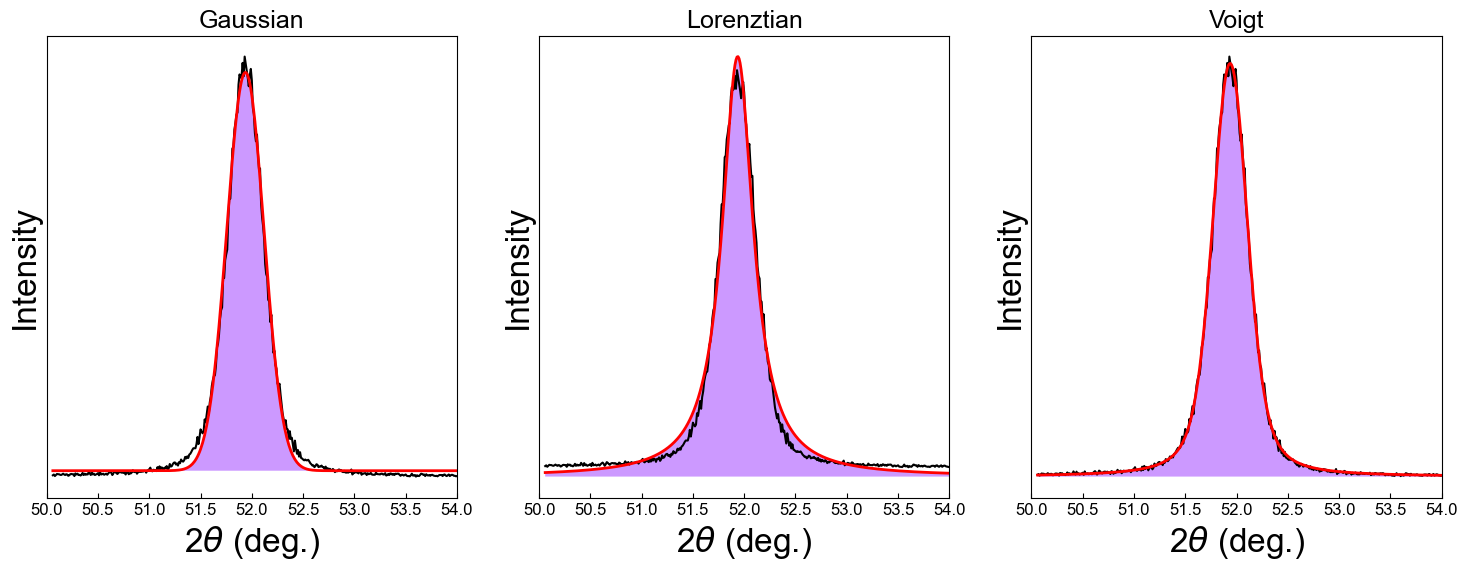

In [62]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

#Gaussisn,Lorentian,Voigt関数でフィッティングしている
#格子定数を求めるときは回折面のミラー指数によって式が変わるのでGaussisn,Lorentian,Voigt関数の格子定数のところを書き換える

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total, maxfev=5000)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)

print('##Gaussian####################')
for i in range(nop):
    opsg=np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2] #面積
    opcg=poptG[3*i+1] #中心
    opfg=abs(2*poptG[3*i+2]) #半値全幅
    oplg=2*1.54/(2*np.sin(np.radians(poptG[3*i+1]/2))) #格子定数
    oplge=np.abs(2*1.54/(2*np.sin(np.radians((poptG[3*i+1]+opfg/2)/2)))-oplg) #エラーバー
    opgg=K*1.54/(np.radians(opfg)*np.cos(np.radians(poptG[3*i+1]/2)))/10 #結晶粒径
    print(f'◯PEAK{i+1}')
    print(f'面積:{opsg}')
    print(f'中心:{opcg}')
    print(f'FWHM (deg.):{opfg}')
    print(f'格子定数 (Å):{oplg}\t±\t{oplge}')
    print(f'結晶粒径 (nm):{opgg}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=24)
plt.yticks([])
plt.xlim(tths,tthe)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=24)
plt.ylabel('Intensity', fontsize=24)
#plt.ylabel('intensity', fontsize=18)

###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)

print('##Lorenztian####################')
for i in range(nop):
    opsl=np.pi/2*poptL[3*i]*abs(poptL[3*i+2]) #面積
    opcl=poptL[3*i+1] #中心
    opfl=abs(poptL[3*i+2]) #半値全幅
    opll=2*1.54/(2*np.sin(np.radians(poptL[4*i+1]/2))) #格子定数
    oplle=np.abs(2*1.54/(2*np.sin(np.radians((poptL[3*i+1]+opfl/2)/2)))-opll) #エラーバー
    opgl=K*1.54/(np.radians(opfl)*np.cos(np.radians(poptL[4*i+1]/2)))/10 #結晶粒径
    print(f'●PEAK{i+1}')
    print(f'面積:{opsl}')
    print(f'中心:{opcl}')
    print(f'FWHM (deg.):{opfl}')
    print(f'格子定数 (Å):{opll}\t±\t{oplle}')
    print(f'結晶粒径 (nm):{opgl}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=24)
plt.yticks([])
plt.xlim(tths,tthe)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=24)
plt.ylabel('Intensity', fontsize=24)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptL[3*i],poptG[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    opsv=poptV[4*i] #面積
    opcv=poptV[4*i+1] #中心
    opfv=2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2)) #半値全幅
    oplv=2*1.54/(2*np.sin(np.radians(poptV[4*i+1]/2))) #格子定数
    oplve=np.abs(2*1.54/(2*np.sin(np.radians((poptV[3*i+1]+opfv/2)/2)))-oplv) #エラーバー
    opgv=K*1.54/(np.radians(opfv)*np.cos(np.radians(poptV[4*i+1]/2)))/10 #結晶粒径
    print(f'●PEAK{i+1}')
    print(f'面積:{opsv}')
    print(f'中心:{opcv}')
    print(f'FWHM:{opfv}')
    print(f'格子定数 (Å):{oplv}\t±\t{oplve}')
    print(f'結晶粒径 (nm):{opgg}')
    
plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=12)
plt.yticks(fontsize=24)
plt.yticks([])
plt.xlim(tths,tthe)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=24)
plt.ylabel('Intensity', fontsize=24)

###テキストに保存###
with open(f'{save_path}/fixed_{filename}_analyzed.txt','a') as f:
    f.write(f"##Gaussian########## \n")
    f.write(f"面積 \t\t:{opsg}\n")
    f.write(f"中心 \t\t:{opcg}\n")
    f.write(f"FWHM \t\t:{opfg}\n")
    f.write(f"格子定数 (Å) \t\t:{oplg}\t±\t{oplge}\n")
    f.write(f"格子定数エラーバー \t\t:{oplge}\n")
    f.write(f"結晶粒径 \t\t:{opgg}\n")
    f.write(f"##Lorenztian########## \n")
    f.write(f"面積 \t\t:{opsl}\n")
    f.write(f"中心 \t\t:{opcl}\n")
    f.write(f"FWHM \t\t:{opfl}\n")
    f.write(f"格子定数 (Å) \t\t:{opll}\t±\t{oplle}\n")
    f.write(f"格子定数エラーバー \t\t:{oplle}\n")
    f.write(f"結晶粒径 \t\t:{opgl}\n")
    f.write(f"##Voigt########## \n")
    f.write(f"面積 \t\t:{opsv}\n")
    f.write(f"中心 \t\t:{opcv}\n")
    f.write(f"FWHM \t\t:{opfv}\n")
    f.write(f"格子定数 (Å) \t\t:{oplv}\t±\t{oplve}\n")
    f.write(f"格子定数エラーバー \t\t:{oplve}\n")
    f.write(f"結晶粒径 \t\t:{opgv}\n")
    

plt.show()

fig.savefig(f'{save_path}/fixed_{filename}.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
fig.savefig(f'{save_path}/fixed_{filename}.png',format="png", bbox_inches="tight", pad_inches=0.1)

## ?

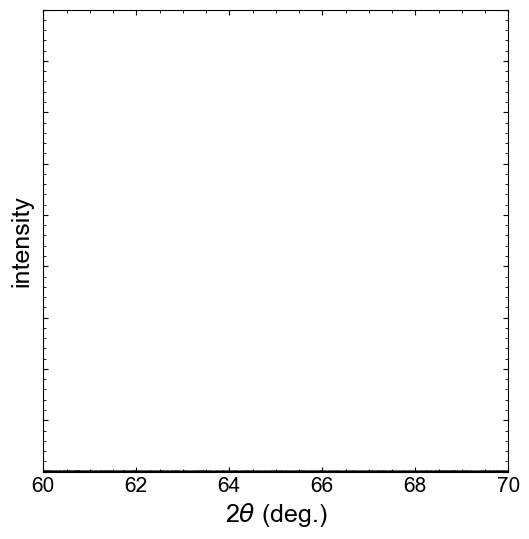

In [22]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

fig = plt.figure(figsize=(6.0, 6.0))
ax = fig.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')



#plt.vlines(64.568,0, 1000, colors='BLACK', linestyle='dashed', linewidth=1)
#plt.text(63,500,"Cr (002)",rotation='vertical',fontsize=15)
#plt.text(46,500,"MgO (002)",rotation='vertical',fontsize=15)

##生データ
plt.plot(xr_list, yr_list,color='BLACK',lw=1.5)
plt.plot(x0_list, fitV , ls='-', c='red', lw=1)
y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)


#plt.yscale('log')
plt.ylim(0, 9000)
plt.xlim(60, 70)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.minorticks_on()
#plt.grid(True)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
plt.ylabel('intensity', fontsize=18)  
plt.tick_params(labelleft=False)

fig.savefig(f'{Path}/{dataname}/peak_.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
    

# Rocking curve parallel to Cr001

In [28]:
#####データの代入############################################
Path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd'
dataname='241031'
filename='241031co_70deg_2_rc'
save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/新試料/xrd-rc'

#見たい角度の範囲(thes=始まり、thee=終わり)
thes=10
thee=40

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(220):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if thes<= float(data[0]) <=thee:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
        
x_RC_Cr=x0_list
y_RC_Cr=y0_list

In [30]:
##初期パラメータ(大体の値を代入)
#見たい試料の001ピーク強度
#RCの強度とピーク角度と半値幅
#amp=200
guess = [] #[amp,ctr,wid]
guess.append([20,25.5,3])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
nop=int(len(guess_total)/3)
guess_total.append(background)

print(nop)

1


##Gaussian####################
◯PEAK1
面積:75.67296859330095
中心:25.401747766148404
全半値幅:6.422234260578082
##Lorenztian####################
●PEAK1
面積:133.9070898094711
中心:25.23817122281904
全半値幅:7.87987418118593
##Voigt##########
●PEAK1
面積:7.241114864756813
中心:25.73069178776643
全半値幅:4.153535190371969


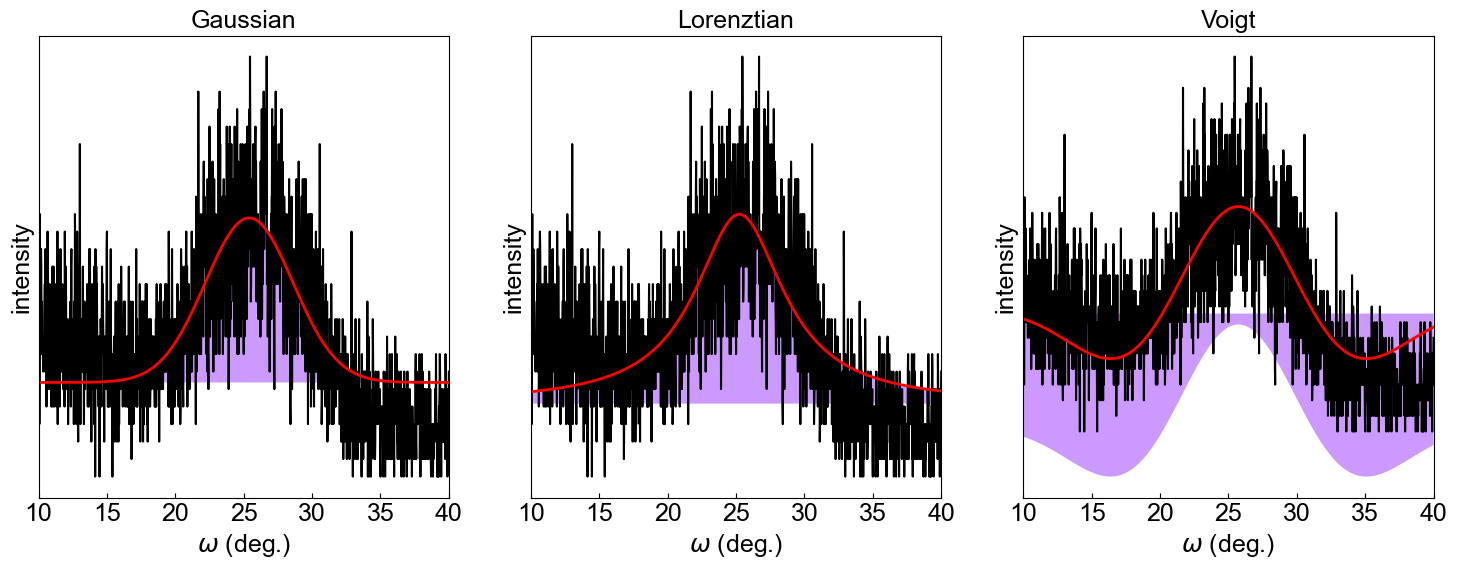

In [32]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    sg=np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]
    cg=poptG[3*i+1]
    fg=2*poptG[3*i+2]
    print(f'◯PEAK{i+1}')
    print(f'面積:{sg}')
    print(f'中心:{cg}')
    print(f'全半値幅:{fg}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks([])
plt.xlim(thes,thee)
plt.title('Gaussian', fontsize=18)
plt.xlabel('$\it{ω}$ (deg.)', fontsize=18)
plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    sl=np.pi/2*poptL[3*i]*abs(poptL[3*i+2])
    cl=poptL[3*i+1]
    fl=abs(poptL[3*i+2])
    print(f'●PEAK{i+1}')
    print(f'面積:{sl}')
    print(f'中心:{cl}')
    print(f'全半値幅:{fl}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks([])
plt.xlim(thes,thee)
plt.title('Lorenztian', fontsize=18)
plt.ylabel('intensity', fontsize=18)
plt.xlabel('$\it{ω}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    sv=poptV[4*i]
    cv=poptV[4*i+1]
    fv=2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))
    print(f'●PEAK{i+1}')
    print(f'面積:{sv}')
    print(f'中心:{cv}')
    print(f'全半値幅:{fv}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)
plt.ylabel('intensity', fontsize=18)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks([])
plt.xlim(thes,thee)
plt.title('Voigt', fontsize=18)
plt.ylabel('intensity', fontsize=18)
plt.xlabel('$\it{ω}$ (deg.)', fontsize=18)

###テキストに保存###
with open(f'{save_path}/fixed_{filename}_analyzed.txt','a') as f:
    f.write(f"##Gaussian########## \n")
    f.write(f"面積 \t\t:{sg}\n")
    f.write(f"中心 \t\t:{cg}\n")
    f.write(f"FWHM \t\t:{fg}\n")
    f.write(f"##Lorenztian########## \n")
    f.write(f"面積 \t\t:{sl}\n")
    f.write(f"中心 \t\t:{cl}\n")
    f.write(f"FWHM \t\t:{fl}\n")
    f.write(f"##Voigt########## \n")
    f.write(f"面積 \t\t:{sv}\n")
    f.write(f"中心 \t\t:{cv}\n")
    f.write(f"FWHM \t\t:{fv}\n")

plt.show()
fig.savefig(f'{save_path}/{filename}.pdf',format="pdf", bbox_inches="tight", pad_inches=0.1)
fig.savefig(f'{save_path}/{filename}.png',format="png", bbox_inches="tight", pad_inches=0.1)


# プロット

## 2θ/ω

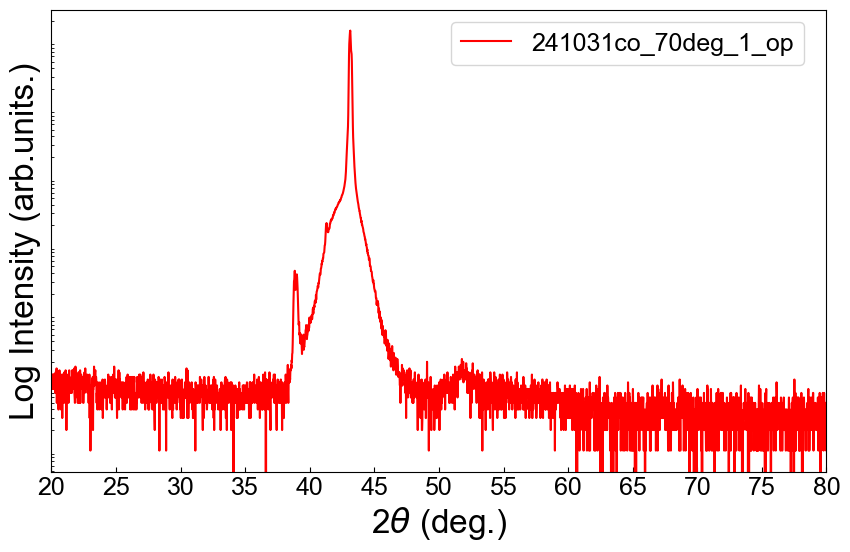

In [43]:
#####データの代入############################################
Path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd' #データファイルのパス
dataname='241031' #データのはいっているファイルの名前
filename='241031co_70deg_1_op' #生データの名前
save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/新試料/xrd'

tths=20
tthe=80

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

#2θ/ω
f= open(f'{Path}/{dataname}/{filename}.txt','rt')

#インプレーン
#f= open(f'{Path}/{dataname}/{filename}.TXT','rt')

#2θ/ω
for i in range(221):

#インプレーン
#for i in range(22):

    next(f)
for line in f :
    data = line[:-1].split(',')
    if tths<= float(data[0]) <=tthe:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    
##保存先のファイルネーム
output_filename=f'summary_{dataname}_pltop.xlsx'


#プロット
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(10.0, 6.0))

plt.yscale('log')
plt.plot(x0_list,y0_list,c='RED', label=(filename))
plt.legend(bbox_to_anchor=(0.5, 1.0), loc='upper left',fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.xlim(tths,tthe)
plt.xticks(np.arange(tths,tthe+1,5),fontsize=18)
plt.yticks([])
plt.ylabel('Log Intensity (arb.units.)', fontsize=24)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=24)

#ピーク理論値
#plt.axvline( x=65 , ymin=0 , ymax=100  ,linestyle="-.", color="black", label="$K_{1}$=0 line")

plt.show()

fig.savefig(f'{save_path}/plt_{filename}.pdf',bbox_inches="tight",format="pdf", pad_inches=0.1)
fig.savefig(f'{save_path}/plt_{filename}.png',format="png", bbox_inches="tight", pad_inches=0.1)

## phi-scan

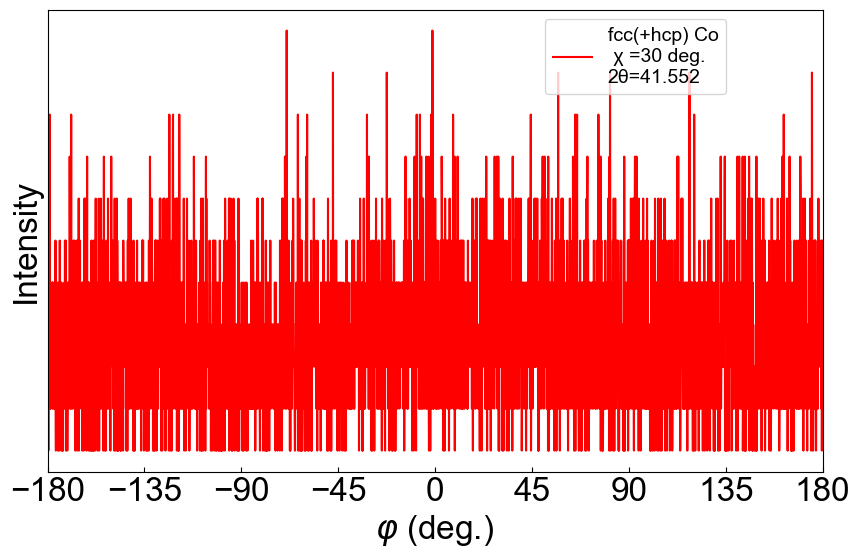

In [67]:
#####データの代入############################################
#main_sample
Path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd'
dataname='241108'
filename='231011co4a_kai30'
save_path='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/解析/新試料/xrd'

#substarate
Path_s='/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd'
dataname_s='240311'
filename_s='240311nicofe10-1-mgo111'

#220 or 111?
#subname='MgO(220)'
subname='MgO(111)'

tths=-180
tthe=180

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

x1_list=[]
y1_list=[]
xr1_list=[]
yr1_list=[]

#2θ/ω
f= open(f'{Path}/{dataname}/{filename}.txt','rt')

#2θ/ω
for i in range(221):

    next(f)
for line in f :
    data = line[:-1].split(',')
    if tths<= float(data[0]) <=tthe:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

#phi
f= open(f'{Path_s}/{dataname_s}/{filename_s}.txt','rt')

for i in range(221):

    next(f)
for line in f :
    data = line[:-1].split(',')
    if tths<= float(data[0]) <=tthe:
        x1_list.append(float(data[0]))
        y1_list.append(float(data[1]))
        xr1_list.append(float(data[0]))
        yr1_list.append(float(data[1]))
    else:
        xr1_list.append(float(data[0]))
        yr1_list.append(float(data[1]))

    
##保存先のファイルネーム
output_filename=f'summary_{dataname}_pltphi.xlsx'


plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(10.0, 6.0))

#plt.yscale('log')
plt.plot(x0_list,y0_list,c='RED',label='fcc(+hcp) Co\n χ =30 deg.\n2θ=41.552')  #sample_plt
#plt.plot(x1_list,y1_list,c='BLUE',label=(subname)) #sub_plt
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.xlim(tths,tthe)
plt.xticks(np.arange(tths,tthe+1,45),fontsize=24)
plt.yticks([])
plt.ylabel('Intensity', fontsize=24)
plt.xlabel('$\it{φ}$ (deg.)', fontsize=24)
plt.legend(bbox_to_anchor=(0.63, 1.0), loc='upper left',fontsize=14)

plt.show()
fig.savefig(f'{save_path}/plt_{filename}.pdf',bbox_inches="tight",format="pdf", pad_inches=0.1)
fig.savefig(f'{save_path}/plt_{filename}.png',format="png", bbox_inches="tight", pad_inches=0.1)

# 2θ/ω-scan parallel to Cr110

In [22]:
#####データの代入############################################
filename='A19-rc'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 40<= float(data[0]) <=50:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(6.0, 6.0))

plt.plot(x0_list,y0_list,c='Black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.xlim(44,46)
plt.xticks(np.arange(44,46,0.2))
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ueno2/iCloudDrive/研究/FeCoNi3元合金/データ/xrd/20230525/A18-oop/A19-rc.txt'

In [ ]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
guess = [] #[amp,ctr,wid]
guess.append([3000,44.6,0.5])
guess.append([16000,44.8,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
nop=int(len(guess_total)/3)
guess_total.append(background)

print(nop)

##Gaussian####################
◯PEAK1
面積:501.32565492620006
中心:52.1
全半値幅:2.0
##Lorenztian####################
●PEAK1
面積:-2967208273.68077
中心:13316.231942685657
全半値幅:1655.9072970299637
##Voigt##########
●PEAK1
面積:-23997.1966145045
中心:2082158.5627334793
全半値幅:-51287.1999298468


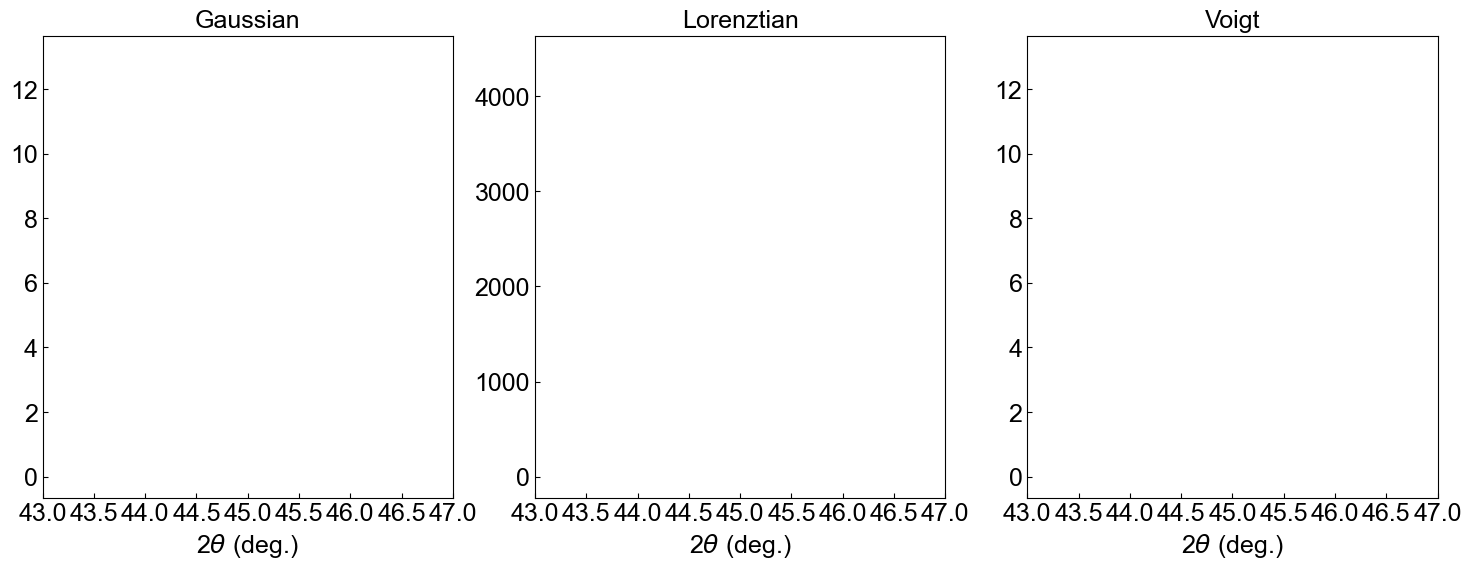

In [ ]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total,maxfev=5000)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(43,47)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(43,47)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V, maxfev=10000)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(43,47)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


# Rocking curve parallel to Fe002

In [ ]:
#####データの代入############################################
filename='RC_Fe002'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 30<= float(data[0]) <=35:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

x_RC_Fe=x0_list
y_RC_Fe=y0_list

In [ ]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
amp=250
guess = [] #[amp,ctr,wid]
guess.append([amp,32.284,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

In [ ]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31.5,34.5)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31.5,34.5)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(31.5,34.5)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


In [7]:
plt.plot(x_RC_Cr,y_RC_Cr)
plt.plot(x_RC_Fe,y_RC_Fe)

NameError: name 'x_RC_Cr' is not defined

In [8]:
#####データの代入############################################
dataname='MgOsubs'
filename='RC_MgO002'

x0_list=[]
y0_list=[]
xr_list=[]
yr_list=[]

f= open(f'{Path}/{dataname}/{filename}.txt','rt')
for i in range(256):
    next(f)
for line in f :
    data = line[:-1].split(',')
    if 20<= float(data[0]) <=23:
        x0_list.append(float(data[0]))
        y0_list.append(float(data[1]))
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))
    else:
        xr_list.append(float(data[0]))
        yr_list.append(float(data[1]))

x_RC_Fe=x0_list
y_RC_Fe=y0_list

NameError: name 'Path' is not defined

In [9]:
##初期パラメータ(大体の値を代入)
#Crの001ピーク強度
amp=35000
guess = [] #[amp,ctr,wid]
guess.append([amp,21.408,0.5])
background = 5
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)

In [10]:
%matplotlib inline
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special

plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure(figsize=(18.0, 6.0))

data=[]
data.clear()
data.append(x0_list)
data.append(x0_list)

###Gaussian#########################
poptG, pcovG = curve_fit(Gaussian, x0_list, y0_list, p0=guess_total)
fitG = Gaussian(x0_list, *poptG)
data.append(fitG)
print('##Gaussian####################')
for i in range(nop):
    print(f'◯PEAK{i+1}')
    print(f'面積:{np.sqrt(2*np.pi)*poptG[3*i]*poptG[3*i+2]}')
    print(f'中心:{poptG[3*i+1]}')
    print(f'全半値幅:{abs(2*poptG[3*i+2])}')

plt.subplot(1,3,1)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitG , ls='-', c='red', lw=2)

y_list = plot_G(x0_list, *poptG)
baseline = np.zeros_like(x0_list)+poptG[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)
    
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(20.6,22)
plt.title('Gaussian', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)
#plt.ylabel('intensity', fontsize=18)



###Lorenztian######################
poptL, pcovL = curve_fit(Lorentzian, x0_list, y0_list, p0=guess_total)
fitL = Lorentzian(x0_list, *poptL)
print('##Lorenztian####################')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{np.pi/2*poptL[3*i]*abs(poptL[3*i+2])}')
    print(f'中心:{poptL[3*i+1]}')
    print(f'全半値幅:{abs(poptL[3*i+2])}')

plt.subplot(1,3,2)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitL , ls='-', c='red', lw=2)

y_list = plot_L(x0_list, *poptL)
baseline = np.zeros_like(x0_list)+poptL[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(20.6,22)
plt.title('Lorenztian', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###Voigt######################
guessV = [] #[norm,ctr,lw,gw]
for i in range(nop):
    guessV.append([poptG[3*i],poptL[3*i+1],abs(poptL[3*i+2]),abs(poptG[3*i+2])])
background = 5
guess_total_V = []
for i in guessV:
    guess_total_V.extend(i)
guess_total_V.append(background)

poptV, pcovV = curve_fit(Voigt, x0_list, y0_list, p0=guess_total_V)
fitV = Voigt(x0_list, *poptV)
print('##Voigt##########')
for i in range(nop):
    print(f'●PEAK{i+1}')
    print(f'面積:{poptV[4*i]}')
    print(f'中心:{poptV[4*i+1]}')
    print(f'全半値幅:{2*(0.5346*poptV[4*i+2]+np.sqrt(0.2166*poptV[4*i+2]**2+poptV[4*i+3]**2))}')

plt.subplot(1,3,3)
plt.plot(x0_list, y0_list,c='Black')
plt.plot(x0_list, fitV , ls='-', c='red', lw=2)

y_list = plot_V(x0_list, *poptV)
baseline = np.zeros_like(x0_list)+poptV[-1]
for n,i in enumerate(y_list):
    plt.fill_between(x0_list, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.4)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(20.6,22)
plt.title('Voigt', fontsize=18)
#plt.ylabel('intensity', fontsize=18)
plt.xlabel('2$\it{θ}$ (deg.)', fontsize=18)

###エクセルに保存###

plt.show()


ValueError: `ydata` must not be empty!

<Figure size 1800x600 with 0 Axes>